# Brain Tumor Detection using Transfer Learning (Keras EfficientNetB0)

### Import required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications.VGG16 import preprocess_input

### Prepare the data

In [2]:
import os
import cv2

data_dir = "../data/Training" 

etiquetas = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X = []
y = []

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  

for idx, etiqueta in enumerate(etiquetas):
    carpeta = os.path.join(data_dir, etiqueta)
    for img_name in os.listdir(carpeta):
        img_path = os.path.join(carpeta, img_name)
        
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img_gray is not None:
            img_clahe = clahe.apply(img_gray) # I use CLAHE to apply contrast.
            img_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
            img_resized = cv2.resize(img_rgb, (224, 224))
            
            X.append(img_resized)
            y.append(idx)

X = np.array(X)
y = np.array(y)

X = preprocess_input(X)  # Normalize as EfficientNet expect

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes:
X_train: (2296, 224, 224, 3)
X_test: (574, 224, 224, 3)
y_train: (2296,)
y_test: (574,)


### I add generators for data augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as idg

datagen = idg(
    rotation_range=10,              
    width_shift_range=0.05,         
    height_shift_range=0.05,        
    zoom_range=0.1,                 
    brightness_range=[0.9, 1.1],    
    horizontal_flip=True,           
    fill_mode='nearest'             
)

datagen.fit(X_train)

### I show images to check if I have prepared the data correctly

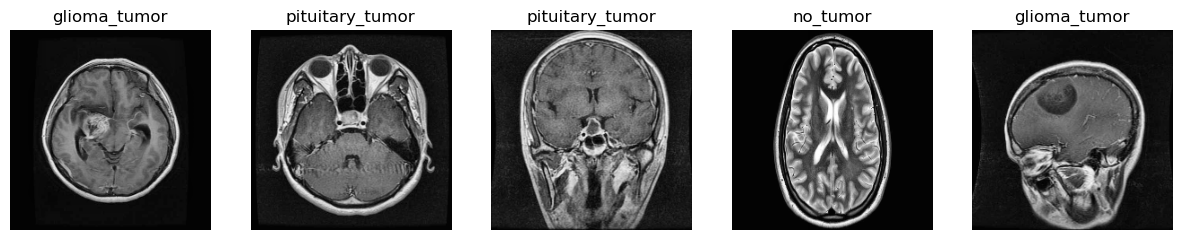

In [4]:
plt.figure(figsize=(15, 5))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(etiquetas[y_train[i]]) 
    plt.axis('off')

plt.show()

### One Hot Encoding on the labels

In [5]:
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

print(y_train_ohe.shape)
print(y_test_ohe.shape)
print(y_train[:5])    
print(y_train_ohe[:5]) 

(2296, 4)
(574, 4)
[0 3 3 1 0]
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


### To save time and improve performance, I’m going to use Transfer Learning

In [6]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True 
for layer in base_model.layers[:-20]: # Only last 20 layers change their weights.
    layer.trainable = False

### After EfficientNet, I need to add layers

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
num_classes = y_train_ohe.shape[1]
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

### Once the model is created, it’s important to check its layers to understand it.

In [8]:
# model.summary()

### Now, we compile the model

In [9]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

### Once compiled, we train it using callbacks to stop if there is no improvement.

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Stops if val_loss doesnt improve.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6) # Reduce LR.
checkpoint = ModelCheckpoint('best_model_ENB0.keras', monitor='val_loss', save_best_only=True) # Keeps best model.

callbacks = [early_stopping, reduce_lr, checkpoint]

model.fit(
    datagen.flow(X_train, y_train_ohe, batch_size=32),
    validation_data=(X_test, y_test_ohe),
    epochs=25,
    callbacks=callbacks,
    verbose=1
)

E:\Programas\Anaconda\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7244 - loss: 0.6917 - val_accuracy: 0.7944 - val_loss: 0.7726 - learning_rate: 0.0010
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 61s 828ms/step - accuracy: 0.9047 - loss: 0.2545 - val_accuracy: 0.8815 - val_loss: 0.3943 - learning_rate: 0.0010
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 784ms/step - accuracy: 0.9366 - loss: 0.1621 - val_accuracy: 0.9007 - val_loss: 0.2921 - learning_rate: 0.0010
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 765ms/step - accuracy: 0.9587 - loss: 0.1186 - val_accuracy: 0.9077 - val_loss: 0.3602 - learning_rate: 0.0010
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 777ms/step - accuracy: 0.9554 - loss: 0.1037 - val_accuracy: 0.8972 - val_loss: 0.2727 - learning_rate: 0.0010
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 765ms/step - accuracy: 0.9699 - loss: 0.0859 - val_accuracy: 0.9129 - val_loss: 0.3288 - learning_rate: 0.0010
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 775ms/step - accuracy: 0.9708 - loss: 0.083

### We generate a confusion matrix and a classification report to analyze the model's performance.

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=etiquetas,
            yticklabels=etiquetas)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 609ms/step


In [12]:
report = classification_report(y_true, y_pred_classes, target_names=etiquetas)
print(report)

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.98      0.97       165
        no_tumor       0.97      0.96      0.97        79
meningioma_tumor       0.97      0.90      0.94       165
 pituitary_tumor       0.94      1.00      0.97       165

        accuracy                           0.96       574
       macro avg       0.96      0.96      0.96       574
    weighted avg       0.96      0.96      0.96       574



### These are very optimal results, showing high precision, recall, and F1-scores across all tumor classes. 

### Given this strong performance, we will keep this model for further use.